In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
# filter warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import time
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

torch.manual_seed(17)

In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv",dtype = np.float32)
test = pd.read_csv("../input/digit-recognizer/test.csv",dtype = np.float32)
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train set shape: (42000, 785)
Test set shape: (28000, 784)


In [6]:
# put labels into y_train variable
Y = train["label"]
# Drop 'label' column
X = train.drop(labels = ["label"],axis = 1) 

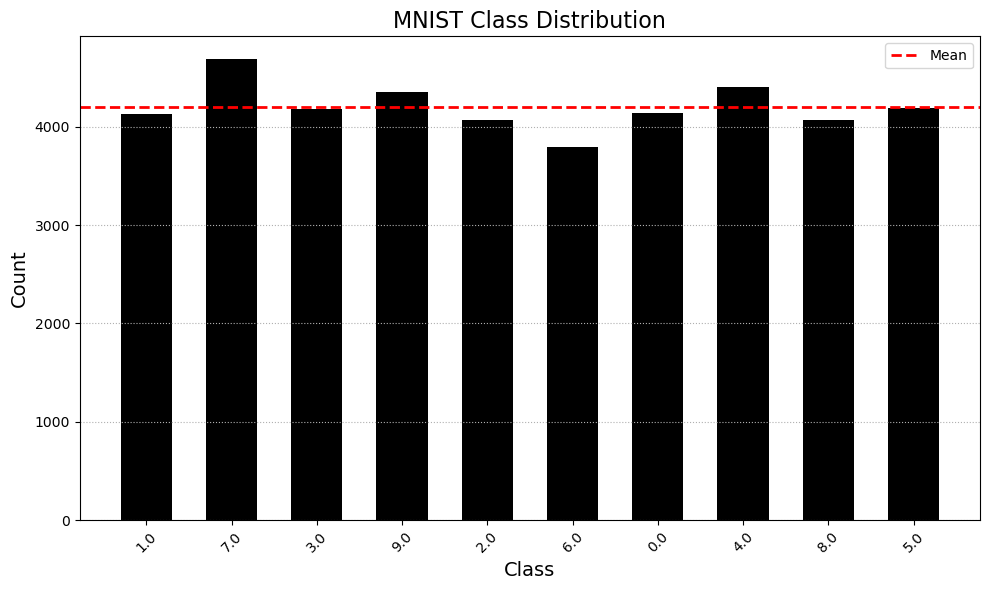

In [7]:
# Sınıf etiketleri ve sayıları
labels = Y.value_counts().index
counts = Y.value_counts()

# Özelleştirmeler
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu arttıralım
plt.bar(labels, counts, color='black', width=0.6)  # Renk ve çubuk genişliği ayarları
plt.xticks(np.arange(len(labels)), labels, rotation=45)  # X eksenine sınıf etiketlerini döndürerek ekleyelim
plt.xlabel('Class', fontsize=14)  # X eksenine etiket ekleyelim
plt.ylabel('Count', fontsize=14)  # Y eksenine etiket ekleyelim
plt.title('MNIST Class Distribution', fontsize=16)  # Grafiğe başlık ekleyelim

# Yatay bir çizgi ekleyelim, tüm sınıfların eşit dağıtıldığını görsel olarak gösterelim
plt.axhline(counts.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')  

plt.legend()  # Açıklamaları gösterelim
plt.grid(axis='y', linestyle='dotted')  # Y eksenine ızgara ekleyelim

plt.tight_layout()  # Grafiği daha düzenli hale getirelim
plt.show()  # Grafiği gösterelim

7.0, 5.0, 1.0, 9.0, 9.0, 8.0, 1.0, 1.0


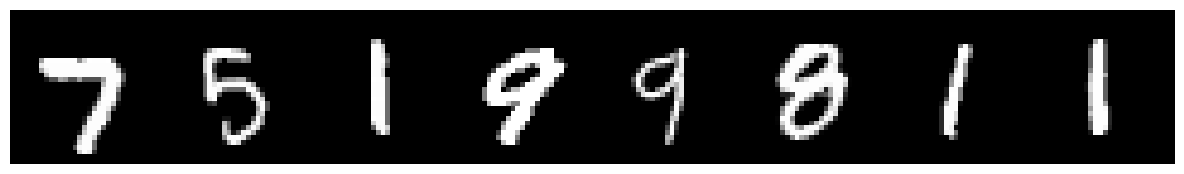

In [8]:
from torchvision.utils import make_grid
random_sel = np.random.randint(len(train), size=8)

grid = make_grid(torch.Tensor((train.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train.iloc[random_sel, 0].values), sep = ', ')

In [9]:
# Normalize the data
X = X / 255.0
test = test / 255.0
print("X Shape: ",X.shape)
print("Test Shape: ",test.shape)

X Shape:  (42000, 784)
Test Shape:  (28000, 784)


In [10]:
from sklearn.model_selection import train_test_split
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.1, random_state=45)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (37800, 784)
x_val shape (4200, 784)
y_train shape (37800,)
y_val shape (4200,)


In [11]:
test = torch.from_numpy(test.values.reshape((-1,1,28,28)))
X_train = torch.from_numpy(X_train.values.reshape((-1,1,28,28)))
y_train= torch.from_numpy(y_train.values)
X_val = torch.from_numpy(X_val.values.reshape((-1,1,28,28)))
y_val = torch.from_numpy(y_val.values)

In [12]:
# define own dataset
class MNISTDataset(Dataset):
    """MNIST dataset"""
    
    def __init__(self, feature, target=None, transform=None):
        
        self.X = feature
        self.y = target
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # training
        if self.transform is not None:
            return self.transform(self.X[idx]), self.y[idx]
        # testing
        elif self.y is None:
            return [self.X[idx]]
        # validation
        return self.X[idx], self.y[idx]

In [13]:
batch_size=64

In [14]:
# define transform operation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()])

# create dataset
train= MNISTDataset(X_train.float(), y_train.long(), transform=data_transform)
val = MNISTDataset(X_val.float(), y_val.long())
test = MNISTDataset(test.float())

In [15]:
# load the data
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
validate_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [16]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [17]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [18]:
model = ResNet_18(1, 10)

In [19]:
#define everything we need for training
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch [{}/{}],'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:  # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:  # Iterate over data
                inputs = transforms.functional.resize(inputs, (112, 112))

                optimizer.zero_grad()  # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'):  # Forward. Track history if only in train
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':  # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'val':  # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, {} Accuracy: {:.2f}%'.format(phase.capitalize(), epoch_loss, phase.capitalize(), epoch_acc * 100))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:.2f}%'.format(best_acc * 100))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
model, val_acc_history = train_model(model, {"train": train_loader, "val": validate_loader}, criterion, optimizer, num_epochs=epochs)

Epoch [1/5],
----------
Train Loss: 0.2874, Train Accuracy: 90.94%
Val Loss: 0.0710, Val Accuracy: 97.93%

Epoch [2/5],
----------
Train Loss: 0.1085, Train Accuracy: 96.69%
Val Loss: 0.0740, Val Accuracy: 97.79%

Epoch [3/5],
----------
Train Loss: 0.0862, Train Accuracy: 97.32%
Val Loss: 0.0580, Val Accuracy: 98.17%

Epoch [4/5],
----------
Train Loss: 0.0751, Train Accuracy: 97.67%
Val Loss: 0.0446, Val Accuracy: 98.67%

Epoch [5/5],
----------
Train Loss: 0.0701, Train Accuracy: 97.87%
Val Loss: 0.0390, Val Accuracy: 98.86%

Training complete in 128m 45s
Best Validation Accuracy: 98.86%
